#### This program computes the linear regression coefficients and intercept to predict the Zn Drop in  106TK01 from the following features:
1. dezn flow
2. dezn feed temp
3. 105tk05 temp
4. H2S flow to dezn
5. ntrl pls condition
6. 105TK03 AAS Zn
7. 105TK05 pls analysis
(Ridge regression) Tensorflow is used.


This is a continuation from the ZnNi_Proj_Load_Data_Gathered_2015_to_2020Aug.ipynb file

In [21]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.parser import parse
from itertools import compress
from collections import OrderedDict
from datetime import date
import datetime
from datetime import timedelta
import re

import openpyxl
import random

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [22]:
#-------Load the DF_combined data from ZnDrop_Proj_Load_Data_Gathered_2017_to_2020Aug.ipynb file

# ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltd_2015_2020_PIdata_DF.xlsx ---> previous version dataset
# The ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltdLINEAR_2015_2020_PIdata_DF.xlsx dataset is already ret time adjusted for 105 and 106 samples

DF_NTRL_TK03_TK05_MSTK01 = pd.read_excel(r'C:\Users\v.t.flores\Documents\ZnNi_project_NTRL_TK03_TK05_MSTK01_intrpltdLINEAR_2015_2020_PIdata_DF.xlsx')
DF_NTRL_TK03_TK05_MSTK01_1 = DF_NTRL_TK03_TK05_MSTK01.set_index('DATETIME')

#convert the df to numeric
for i in DF_NTRL_TK03_TK05_MSTK01_1.columns:
    DF_NTRL_TK03_TK05_MSTK01_1[i] = pd.to_numeric(DF_NTRL_TK03_TK05_MSTK01_1[i], errors='coerce')
    


In [23]:
# If predicting ZnDrop,  Drop the 106_Zn, 106_Ni and tk03_zn columns
#DF_main_20152020 = DF_NTRL_TK03_TK05_MSTK01_1.drop(['106_Zn', '106_Ni', 'tk03_Zn'], axis=1)
#DF_MAIN_2015_2020 = DF_main_20152020.dropna()

# If predicting 106_Zn, Drop the 106_Ni , Zn_Drop and tk03_zn columns
DF_main_20152020 = DF_NTRL_TK03_TK05_MSTK01_1.drop(['Zn_Drop', '106_Ni', 'tk03_Zn', '106_Zn'], axis=1)
DF_MAIN_2015_2020 = DF_main_20152020.dropna()

DF = DF_MAIN_2015_2020
DF = DF.drop((DF[(DF['104_pH60']<2.0) | (DF['104_pH60']>4.0)].index))
DF = DF.drop((DF[DF['104_Fe']<0.1].index))
DF = DF.drop((DF[DF['104_NTU']>1000].index))
DF = DF.drop((DF[(DF['104_ORP']<90) | (DF['104_ORP']>1000)].index))
DF = DF.drop(DF[DF['104_Mg']<1].index)
DF = DF.drop((DF[DF['104_Pb']>0.001].index))
DF = DF.drop(DF[DF['104_Mn']<1].index)
DF = DF.drop(DF[DF['104_Al']<1].index)
DF = DF.drop(DF[DF['104_Si']>2].index)
DF = DF.drop(DF[DF['104_Zn']>0.2].index)
DF = DF.drop(DF[DF['104_Cu']>0.1].index)
DF = DF.drop(DF[DF['104_Fe2']<0.01].index)
DF = DF.drop(DF[DF['104_Cr']<0.05].index)
DF = DF.drop(DF[DF['104_Ca']<0.09].index)
DF = DF.drop(DF[DF['tk05_Ca']<0.01].index)
DF = DF.drop(DF[DF['tk05_Al']<1.0].index)
DF = DF.drop(DF[DF['tk05_Co']<0.04].index)
DF = DF.drop(DF[DF['tk05_Co']>0.9].index)
DF = DF.drop(DF[DF['tk05_Zn']<0.0001].index)
# Scale up the '106_Zn' analysis results for better neural net performance
DF['tk05_Zn']=DF['tk05_Zn']*1000

#### Try to do the tensorflow modelling in this notebook because exporting to excel may limit the maximum negative float number

In [24]:
import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [25]:
columns_include = ['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu',
                   '104_Fe', '104_Fe2','104_Ft', '104_Mg', '104_Mn', 
                   '104_NTU', '104_Ni', '104_ORP', '104_Pb','104_Si', 
                   '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T','DeZn_TK05_T', 
                   'H2S_tk01', 'H2S_tk02', 'tk05_Zn']
dataset2 = DF
dataset2 = dataset2[columns_include]
dataset2 = dataset2.drop(dataset2.loc['2020-08-01 00:00:00':'2020-10-07 00:00:00'].index) # remove the august and september2020 data to prior to training

In [26]:
# linear
train_dataset2 = dataset2.sample(frac=0.8, random_state=0)
test_dataset2 = dataset2.drop(train_dataset2.index)

# Also look at the overall statistics:

# linear
train_stats = train_dataset2.describe()
train_stats.pop('tk05_Zn')
train_stats = train_stats.transpose()

#Separate the target value, or "label", from the features. 
#This label is the value that you will train the model to predict.

# Linear
train_labels = train_dataset2.pop('tk05_Zn')
test_labels = test_dataset2.pop('tk05_Zn')

# Linear
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset2)
normed_test_data = norm(test_dataset2)


# add regularization parameters to the model
def build_model():
    model = keras.Sequential([
    layers.Dense(320, activation=tf.nn.relu, 
                 kernel_regularizer=regularizers.l2(0.0001), 
                 input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.5),
    layers.Dense(320, activation=tf.nn.relu,
                kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(320, activation=tf.nn.relu,
                kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),  
    layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'accuracy'])
    return model


# Display training progress by printing a single dot for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [tk05_Zn]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label= 'Val Error')
    plt.legend()

# testing Linear

model = keras.Sequential([layers.Dense(320, activation=tf.nn.relu, 
                                       kernel_regularizer=regularizers.l2(0.0001), 
                                       input_shape=[len(normed_train_data.keys())]),
                          layers.Dropout(0.5),
                          layers.Dense(320, activation=tf.nn.relu,
                                       kernel_regularizer=regularizers.l2(0.0001)),
                          layers.Dropout(0.5),
                          layers.Dense(320, activation=tf.nn.relu,
                                       kernel_regularizer=regularizers.l2(0.0001)),
                          layers.Dropout(0.5),
                          layers.Dense(1)])

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop')

model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse', 'accuracy', ])

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', 
                                           patience=20, 
                                           min_delta=0.0001, 
                                           mode='auto', 
                                           verbose=1)
history = model.fit(normed_train_data, 
                    train_labels, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=1, 
                    callbacks=[early_stop])

Train on 19438 samples, validate on 4860 samples
Epoch 1/1000
19438/19438 [==============================] - 3s 137us/sample - loss: 28.3547 - mean_absolute_error: 3.7714 - mean_squared_error: 28.2857 - acc: 0.0039 - val_loss: 27.2408 - val_mean_absolute_error: 3.4170 - val_mean_squared_error: 27.1713 - val_acc: 0.0039
Epoch 2/1000
19438/19438 [==============================] - 2s 88us/sample - loss: 24.3612 - mean_absolute_error: 3.4563 - mean_squared_error: 24.2916 - acc: 0.0039 - val_loss: 23.4519 - val_mean_absolute_error: 3.1643 - val_mean_squared_error: 23.3820 - val_acc: 0.0039
Epoch 3/1000
19438/19438 [==============================] - 2s 91us/sample - loss: 22.6640 - mean_absolute_error: 3.3476 - mean_squared_error: 22.5943 - acc: 0.0039 - val_loss: 22.7738 - val_mean_absolute_error: 3.1444 - val_mean_squared_error: 22.7042 - val_acc: 0.0039
Epoch 4/1000
19438/19438 [==============================] - 2s 90us/sample - loss: 21.7539 - mean_absolute_error: 3.2820 - mean_squared_e

Epoch 31/1000
19438/19438 [==============================] - 2s 90us/sample - loss: 18.6771 - mean_absolute_error: 2.9884 - mean_squared_error: 18.5620 - acc: 0.0039 - val_loss: 20.7570 - val_mean_absolute_error: 2.9567 - val_mean_squared_error: 20.6404 - val_acc: 0.0039
Epoch 32/1000
19438/19438 [==============================] - 2s 107us/sample - loss: 18.9128 - mean_absolute_error: 3.0074 - mean_squared_error: 18.7954 - acc: 0.0039 - val_loss: 20.7418 - val_mean_absolute_error: 2.9697 - val_mean_squared_error: 20.6235 - val_acc: 0.0039
Epoch 33/1000
19438/19438 [==============================] - 2s 99us/sample - loss: 18.7268 - mean_absolute_error: 2.9871 - mean_squared_error: 18.6073 - acc: 0.0039 - val_loss: 20.7772 - val_mean_absolute_error: 2.9507 - val_mean_squared_error: 20.6562 - val_acc: 0.0039
Epoch 34/1000
19438/19438 [==============================] - 2s 89us/sample - loss: 18.9032 - mean_absolute_error: 2.9949 - mean_squared_error: 18.7811 - acc: 0.0039 - val_loss: 20.40

19438/19438 [==============================] - 2s 80us/sample - loss: 19.0667 - mean_absolute_error: 2.9397 - mean_squared_error: 18.8886 - acc: 0.0039 - val_loss: 19.9646 - val_mean_absolute_error: 2.9575 - val_mean_squared_error: 19.7856 - val_acc: 0.0039
Epoch 62/1000
19438/19438 [==============================] - 2s 80us/sample - loss: 18.5185 - mean_absolute_error: 2.9513 - mean_squared_error: 18.3385 - acc: 0.0039 - val_loss: 19.8615 - val_mean_absolute_error: 2.9429 - val_mean_squared_error: 19.6804 - val_acc: 0.0039
Epoch 63/1000
19438/19438 [==============================] - 2s 81us/sample - loss: 19.3717 - mean_absolute_error: 2.9703 - mean_squared_error: 19.1898 - acc: 0.0039 - val_loss: 20.0300 - val_mean_absolute_error: 2.9446 - val_mean_squared_error: 19.8472 - val_acc: 0.0039
Epoch 64/1000
19438/19438 [==============================] - 2s 81us/sample - loss: 18.1657 - mean_absolute_error: 2.9470 - mean_squared_error: 17.9822 - acc: 0.0039 - val_loss: 19.9211 - val_mean_a

19438/19438 [==============================] - 2s 79us/sample - loss: 18.5627 - mean_absolute_error: 2.9218 - mean_squared_error: 18.3420 - acc: 0.0038 - val_loss: 19.6996 - val_mean_absolute_error: 2.9018 - val_mean_squared_error: 19.4784 - val_acc: 0.0039
Epoch 92/1000
19438/19438 [==============================] - 2s 79us/sample - loss: 19.1743 - mean_absolute_error: 2.9217 - mean_squared_error: 18.9528 - acc: 0.0038 - val_loss: 19.8530 - val_mean_absolute_error: 2.9726 - val_mean_squared_error: 19.6314 - val_acc: 0.0039
Epoch 93/1000
19438/19438 [==============================] - 2s 81us/sample - loss: 18.5772 - mean_absolute_error: 2.9309 - mean_squared_error: 18.3546 - acc: 0.0037 - val_loss: 19.5570 - val_mean_absolute_error: 2.9123 - val_mean_squared_error: 19.3336 - val_acc: 0.0039
Epoch 94/1000
19438/19438 [==============================] - 2s 82us/sample - loss: 18.3101 - mean_absolute_error: 2.9035 - mean_squared_error: 18.0860 - acc: 0.0038 - val_loss: 19.6290 - val_mean_a

19438/19438 [==============================] - 2s 84us/sample - loss: 18.0913 - mean_absolute_error: 2.8937 - mean_squared_error: 17.8424 - acc: 0.0038 - val_loss: 19.3502 - val_mean_absolute_error: 2.8345 - val_mean_squared_error: 19.1002 - val_acc: 0.0037
Epoch 122/1000
19438/19438 [==============================] - 2s 80us/sample - loss: 17.6161 - mean_absolute_error: 2.8989 - mean_squared_error: 17.3659 - acc: 0.0038 - val_loss: 19.3263 - val_mean_absolute_error: 2.8924 - val_mean_squared_error: 19.0758 - val_acc: 0.0039
Epoch 123/1000
19438/19438 [==============================] - 2s 79us/sample - loss: 17.7861 - mean_absolute_error: 2.8961 - mean_squared_error: 17.5358 - acc: 0.0038 - val_loss: 19.7518 - val_mean_absolute_error: 2.8940 - val_mean_squared_error: 19.5011 - val_acc: 0.0037
Epoch 124/1000
19438/19438 [==============================] - 2s 78us/sample - loss: 19.6082 - mean_absolute_error: 2.9009 - mean_squared_error: 19.3571 - acc: 0.0038 - val_loss: 19.5048 - val_mea

19438/19438 [==============================] - 2s 95us/sample - loss: 19.7754 - mean_absolute_error: 2.8797 - mean_squared_error: 19.5049 - acc: 0.0038 - val_loss: 19.4117 - val_mean_absolute_error: 2.8579 - val_mean_squared_error: 19.1406 - val_acc: 0.0039
Epoch 152/1000
19438/19438 [==============================] - 2s 85us/sample - loss: 17.6747 - mean_absolute_error: 2.8819 - mean_squared_error: 17.4037 - acc: 0.0038 - val_loss: 19.2277 - val_mean_absolute_error: 2.8751 - val_mean_squared_error: 18.9562 - val_acc: 0.0039
Epoch 153/1000
19438/19438 [==============================] - 2s 77us/sample - loss: 18.1665 - mean_absolute_error: 2.8807 - mean_squared_error: 17.8949 - acc: 0.0037 - val_loss: 19.3820 - val_mean_absolute_error: 2.8678 - val_mean_squared_error: 19.1103 - val_acc: 0.0039
Epoch 154/1000
19438/19438 [==============================] - 2s 86us/sample - loss: 17.7809 - mean_absolute_error: 2.8701 - mean_squared_error: 17.5085 - acc: 0.0037 - val_loss: 19.3453 - val_mea

19438/19438 [==============================] - 2s 83us/sample - loss: 17.7274 - mean_absolute_error: 2.8496 - mean_squared_error: 17.4372 - acc: 0.0038 - val_loss: 19.1862 - val_mean_absolute_error: 2.8622 - val_mean_squared_error: 18.8959 - val_acc: 0.0039
Epoch 182/1000
19438/19438 [==============================] - 2s 98us/sample - loss: 18.6321 - mean_absolute_error: 2.8540 - mean_squared_error: 18.3421 - acc: 0.0037 - val_loss: 19.5650 - val_mean_absolute_error: 2.9056 - val_mean_squared_error: 19.2743 - val_acc: 0.0039
Epoch 00182: early stopping


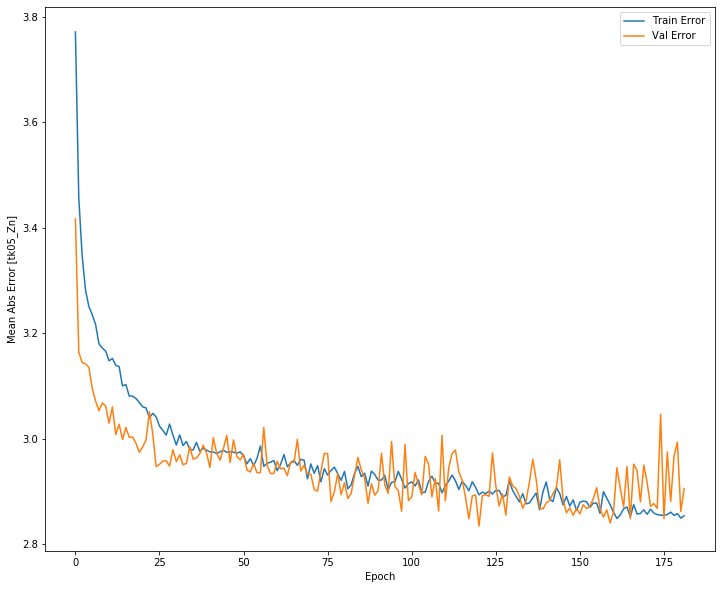

In [27]:
plot_history(history)

In [11]:
model.save(r'C:\Users\v.t.flores\Documents\Zn_tk05_model2') # divide the predicted 106_Zn by 1000 for rescaling correction

#   END of creating a model using linearly interpolated dataset 

##### See  ZnNi_Project_TensorFlow on Regression_ZN jupyter notebook file for the continuation

In [32]:
#used in the analysis results data. cleans up the sampling time entry
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time
def ave_filler(dfname, colname):
    dfcn = dfname[colname]
    try:        
        dfcn = pd.to_numeric(dfcn, errors='coerce')
    except:
        print('error found in' + str(colname))
        pass
    try:
        dfname[colname] = dfcn.where(dfcn.notnull(), other=(dfcn.fillna(method='ffill') + dfcn.fillna(method='bfill'))/2)
    except:
        print('nan not fixed' + str(colname))   
    return dfname
def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df

def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#---------------------------------------

class LabResults():
    def __init__(self, monthyear, filePath):
        #____monthyear format examle is datetime.date(2020,7,1)
        #____filepath example is '\\thgobna001\userdata\THPAL\...\ANALYSIS RESULTS 2020\7) July _2020.xlsx'
        #____add r' at the start of the filepath to apply the regex that allows the use of the filepath as raw
        #____sef.workbook is the uploaded excel workbook of the entire analysis files so it takes time to load
        #____Create an instance of the workbook by giving it a varible name with the sample format: Jan_2020
        
        import openpyxl
        import io
        with open(filePath, "rb") as f:
            in_mem_file = io.BytesIO(f.read())
        
        self.workbook = openpyxl.load_workbook(in_mem_file, data_only=True)
        self.monthyear = monthyear   
        
    def generate_df_from_analysis(self, tabname, list_lab_index):
        #____tabname is a string type name of the tab in the laboratory analysis excel file.
        #____-------Example tabnames: '104PU01', '105TK03', '106TK01'
        #____-------Inside these tabs are the specific analysis results done on the sample taken from the 'tabname' area .
        #____list_lab_index is a list with the sample format is: ['B', 'C', 'E', '104_Pb']
        #____-------the first letter 'B' is the column letter where the day of the month is written as integers 1,2,3..30
        #____-------the second letter 'C' is the column letter where the sampling time is written; e.g. '7:00:00 AM'
        #____-------the third letter 'E' is the column where the results of the specific analysis are listed
        #____-------the last item in the list is the string you'll use as the new title; e.g. '104_Pb'
        
        workbookTab = self.workbook[tabname]
        self.list_lab_index = list_lab_index
        col_sampleDate = self.list_lab_index[0]
        col_sampleTime = self.list_lab_index[1]
        col_analysis = self.list_lab_index[2]
        col_title = self.list_lab_index[3]
        currentmonthyr = self.monthyear
        
        #get the start and end sample dates
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        Smpl_day_index = list()
        Chem_Element_datelist = list()
        Chem_Element_list = list()
        plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
        #gets the date day from the B column of the analysis file if there is value in the cell
        for i in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
                Smpl_day_index.append(i)
        #get the ending row that has date day
        for j in range(1, workbookTab.max_row):
            if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
                smpl_end_index = j
        for y in range(0, len(Smpl_day_index)):
            if Smpl_day_index[y] != Smpl_day_index[-1]:      
                for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                    if workbookTab[str(col_analysis)+str(x)].value is None: 
                        pass
                    else:
                        try:
                            if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                                date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))  
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                            else:
                                date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))  
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                        except:
                            pass

            if Smpl_day_index[y] == Smpl_day_index[-1]:
                for x in range(Smpl_day_index[y], smpl_end_index+1):
                    if workbookTab[str(col_analysis)+str(x)].value is None:   
                        pass
                    else:
                        try:
                            if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                                date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                            else:
                                date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                                +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                                Chem_Element_datelist.append(parse(date))
                                chem_element = workbookTab[str(col_analysis)+str(x)].value
                                Chem_Element_list.append(chem_element)
                        except:
                            pass

        Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
        Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
        Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
        Chem_Element_df.set_index('DATETIME', inplace=True)

        return Chem_Element_df
    
def join_DF(dfsList1):
    df = dfsList1[0]
    for i in range(1,len(dfsList1)):
        df = df.join(dfsList1[i], how='outer')
    return df

def append_monthsDF(dfsListmonthly): #takes the list of dataframes from monthly lab results of one sampling area
    df = dfsListmonthly[0]
    for i in range(1,len(dfsListmonthly)):
        df = df.append(dfsListmonthly[i], ignore_index=True)
    return df    





#used in the analysis results data. cleans up the sampling time entry
def time_cleaner(x):
    time_regex = re.compile(r'[0-8a-zA-Z:]', re.IGNORECASE| re.VERBOSE|re.DOTALL)
    timeact = time_regex.findall(x)
    newtime = ''.join(timeact)
    t = parse(x)
    new_str_time = str(t.hour)+':'+str(t.minute)+':'+str(t.second)
    return new_str_time
def ave_filler(dfname, colname):
    dfcn = dfname[colname]
    try:        
        dfcn = pd.to_numeric(dfcn, errors='coerce')
    except:
        print('error found in' + str(colname))
        pass
    try:
        dfname[colname] = dfcn.where(dfcn.notnull(), other=(dfcn.fillna(method='ffill') + dfcn.fillna(method='bfill'))/2)
    except:
        print('nan not fixed' + str(colname))   
    return dfname
def generate_df_from_analysis(workbookTab, col_sampleDate, col_sampleTime, col_analysis, col_title):
    #get the start and end sample dates
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    Smpl_day_index = list()
    Chem_Element_datelist = list()
    Chem_Element_list = list()
    plus_oneday_list = ['0:0:0', '1:0:0', '2:0:0', '3:0:0', '4:0:0', '5:0:0']
    #gets the date day from the B column of the analysis file if there is value in the cell
    for i in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleDate) + str(i)].value) == int or type(workbookTab[str(col_sampleDate) + str(i)].value) == float:
            Smpl_day_index.append(i)
    #get the ending row that has date day
    for j in range(1, workbookTab.max_row):
        if type(workbookTab[str(col_sampleTime) + str(j)].value) == datetime.datetime:
            smpl_end_index = j
    for y in range(0, len(Smpl_day_index)):
        if Smpl_day_index[y] != Smpl_day_index[-1]:      
            for x in range(Smpl_day_index[y], Smpl_day_index[y+1]):
                if workbookTab[str(col_analysis)+str(x)].value is None: 
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))  
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

        if Smpl_day_index[y] == Smpl_day_index[-1]:
            for x in range(Smpl_day_index[y], smpl_end_index+1):
                if workbookTab[str(col_analysis)+str(x)].value is None:   
                    pass
                else:
                    if time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value)) in plus_oneday_list:
                        date = str((currentmonthyr)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)
                    else:
                        date = str((currentmonthyr)-datetime.timedelta(1)+datetime.timedelta(workbookTab[str(col_sampleDate)+str(Smpl_day_index[y])].value))\
                        +' '+time_cleaner(str(workbookTab[str(col_sampleTime)+str(x)].value))
                        Chem_Element_datelist.append(parse(date))
                        chem_element = workbookTab[str(col_analysis)+str(x)].value
                        Chem_Element_list.append(chem_element)

    Chem_Element_list_pair = list(zip(Chem_Element_list, Chem_Element_datelist[0:]))
    Chem_Element_df = pd.DataFrame(Chem_Element_list_pair)
    Chem_Element_df.columns = [col_title, 'DATETIME'] ##check if list title is updated
    Chem_Element_df.set_index('DATETIME', inplace=True)

    return Chem_Element_df

def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)
#---------------------------------------

#--------------------------------------------------End-------------------------------------------------------------------
#
#
def generate_plot_from_df(figname, df,df_axis_truefalse_list):
    for i in range(0, len(df.columns)):
        colname = df.columns[i]
        figname.add_trace(go.Scatter(x=df[colname].index, y=df[colname], name=colname), secondary_y=df_axis_truefalse_list[i],)
#
#
#--------------------------------------------------------------End-----------------------------------------------------------------------

def generate_add_trace(figname, df_elemental, axis_bool):
    colname = df_elemental.columns[0]
    figname.add_trace(go.Scatter(x=df_elemental.index, y=df_elemental[colname], name=colname), secondary_y=axis_bool,)

    
def load_and_clean_up_Pi_DeZn(Pi_filePath):
    
    df_MSPi = pd.read_excel(Pi_filePath, sheet_name='PI_sept2020', index_col=False)

    #------------------Drop the row[0]. This is the title tag use in the pi datalink. We don't need it in pandas df.
    #------------------What remain are the column title and the rest of the rows of data.

    df_MSPi = df_MSPi.drop(df_MSPi.index[0])

    #Step2: Parse the DATETIME column
    df_MSPi['DATETIME'] = df_MSPi['DATETIME'].apply(lambda x: parse(str(x)))
    df_MSPi.set_index('DATETIME', inplace=True)

    # Step3: Convert each column to numeric to handle nan values and other comments like 'No data...'. Convering to numeric
    #------ converts them into a NaN value that pandas understands.
    for i in df_MSPi.columns:
        df_MSPi[i] = pd.to_numeric(df_MSPi[i], errors='coerce')

    #Creating a column for the correct H2S flowrate
    df_MSPi['H2S_tk01'] = np.where(df_MSPi['H2S_FT_TK01_A']>df_MSPi['H2S_FT_TK01_B'],\
                                        df_MSPi['H2S_FT_TK01_A'], df_MSPi['H2S_FT_TK01_B'])

    df_MSPi['H2S_tk02'] = np.where(df_MSPi['H2S_FT_TK02_A']>df_MSPi['H2S_FT_TK02_B'],\
                                        df_MSPi['H2S_FT_TK02_A'], df_MSPi['H2S_FT_TK02_B'])    

    return df_MSPi    

In [47]:
# month year reference
currentmonthyr_09_2020 = datetime.date(2020,9,1)

#filepath
filepath_09_2020 = r'\\thgobna001\userdata\THPAL\Department\TAGANITO\SHARED\AnalysisResult\ANALYSIS RESULTS 2020\09 SEPTEMBER 2020\9) September _2020.xlsx'

ntrl_Pb_3 = ['B', 'C', 'E', '104_Pb']
ntrl_Zn_3 = ['B', 'C', 'F', '104_Zn']
ntrl_Cu_3 = ['B', 'C', 'G', '104_Cu']
ntrl_Ni_3 = ['B', 'C', 'H', '104_Ni']
ntrl_Co_3 = ['B', 'C', 'I', '104_Co']
ntrl_Fe_3 = ['B', 'C', 'J', '104_Fe']
ntrl_Mn_3 = ['B', 'C', 'K', '104_Mn']
ntrl_Cr_3 = ['B', 'C', 'L', '104_Cr']
ntrl_Ca_3 = ['B', 'C', 'M', '104_Ca']
ntrl_Si_3 = ['B', 'C', 'N', '104_Si']
ntrl_Al_3 = ['B', 'C', 'O', '104_Al']
ntrl_Mg_3 = ['B', 'C', 'P', '104_Mg']
ntrl_Fe2_3 = ['B', 'C', 'R', '104_Fe2']
ntrl_pH60_3 = ['B', 'C', 'BB', '104_pH60'] # check
ntrl_ORP_3 = ['B', 'C', 'AJ', '104_ORP'] 
ntrl_NTU_3 = ['B', 'C', 'AN', '104_NTU'] # check
ntrl_Ft_3 = ['B', 'C', 'AW', '104_Ft'] #check

tk13_Zn_3 = ['B', 'C', 'E', 'tk13_Zn']
tk13_Solids_3 = ['B', 'C', 'AZ', 'tk13_solids%'] #check

MStk01_Zn_drop_3 = ['B', 'C', 'BD', 'Zn_drop']
MStk01_Zn_3 = ['B', 'C', 'F', '106_Zn']
MStk01_Ni_3 = ['B', 'C', 'H', '106_Ni']


tk05_Pb = ['B', 'C', 'E', 'tk05_Pb']
tk05_Zn = ['B', 'C', 'F', 'tk05_Zn']
tk05_Cu = ['B', 'C', 'G', 'tk05_Cu']
tk05_Ni = ['B', 'C', 'H', 'tk05_Ni']
tk05_Co = ['B', 'C', 'I', 'tk05_Co']
tk05_Fe = ['B', 'C', 'J', 'tk05_Fe']
tk05_Mn = ['B', 'C', 'K', 'tk05_Mn']
tk05_Cr = ['B', 'C', 'L', 'tk05_Cr']
tk05_Ca = ['B', 'C', 'M', 'tk05_Ca']
tk05_Si = ['B', 'C', 'N', 'tk05_Si']
tk05_Al = ['B', 'C', 'O', 'tk05_Al']
tk05_Mg = ['B', 'C', 'P', 'tk05_Mg']

tk03_Zn = ['B', 'C', 'D', 'tk03_Zn']
 
monthLab_3 = LabResults(currentmonthyr_09_2020, filepath_09_2020)
df_month_3 = monthLab_3.generate_df_from_analysis('104PU01', ntrl_Pb_3).join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Zn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Cu_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ni_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Co_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Fe_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Mn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Cr_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ca_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Si_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Al_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Mg_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Fe2_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_pH60_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_ORP_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_NTU_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('104PU01', ntrl_Ft_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK13', tk13_Zn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK13', tk13_Solids_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('106TK01', MStk01_Zn_drop_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('106TK01', MStk01_Zn_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('106TK01', MStk01_Ni_3), how='outer').join(
    monthLab_3.generate_df_from_analysis('105TK05', tk05_Pb).join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Zn), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Cu), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Ni), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Co), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Fe), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Mn), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Cr), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Ca), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Si), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Al), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK05', tk05_Mg), how='outer').join(
        monthLab_3.generate_df_from_analysis('105TK03', tk03_Zn), how='outer'))
    
print("sept2020 df done")

sept2020 df done


In [48]:
pi_filePath = r'C:\Users\v.t.flores\Documents\ZnDrop_Project_Pi_Sept2020.xlsx'
df_MSPi = load_and_clean_up_Pi_DeZn(pi_filePath) # see function defn of load_and_clean_up_Pi_DeZn function

DF_labdata_and_Pi_Sept2020 = df_month_3.join(df_MSPi, how='outer')
DF = DF_labdata_and_Pi_Sept2020.interpolate(method='linear', limit_direction='both', axis=0)

In [51]:
DF

,104_Pb,104_Zn,104_Cu,104_Ni,104_Co,104_Fe,104_Mn,104_Cr,104_Ca,104_Si,...,DeZn_Feed_Flow,DeZn_Feed_T,H2S_FT_TK01_A,H2S_FT_TK01_B,H2S_FT_TK02_A,H2S_FT_TK02_B,DeZn_Seed_Flow,DeZn_TK05_T,H2S_tk01,H2S_tk02
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-08-01 00:00:00,0.0000,0.0922,0.0175,3.5940,0.4190,1.4260,NaN,0.1380,0.6900,0.3312,...,1446.023748,65.993175,34.475819,0.013698,-0.713359,80.710809,2.121116,71.392121,34.475819,80.710809
2020-08-01 01:00:00,0.0000,0.0922,0.0175,3.5940,0.4190,1.4260,NaN,0.1380,0.6900,0.3312,...,1445.900731,65.990359,33.311799,0.014167,-0.519754,78.718333,1.924075,71.421656,33.311799,78.718333
2020-08-01 02:00:00,0.0000,0.0922,0.0175,3.5940,0.4190,1.4260,NaN,0.1380,0.6900,0.3312,...,1445.742765,65.988258,30.855416,0.014154,-0.150897,72.580579,2.106740,71.522120,30.855416,72.580579
2020-08-01 03:00:00,0.0000,0.0922,0.0175,3.5940,0.4190,1.4260,NaN,0.1380,0.6900,0.3312,...,1446.107427,65.973705,30.396038,0.013814,-0.322827,70.825251,1.924189,71.540452,30.396038,70.825251
2020-08-01 04:00:00,0.0000,0.0922,0.0175,3.5940,0.4190,1.4260,NaN,0.1380,0.6900,0.3312,...,1474.098454,65.972852,31.119341,0.013500,-0.303644,72.627626,1.930715,71.455304,31.119341,72.627626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06 12:00:00,0.0013,0.0887,0.0156,3.5751,0.3972,1.7267,NaN,0.1265,0.6718,0.2949,...,1049.212731,65.958912,20.385918,0.013333,5.871578,47.861000,1.503820,74.693649,20.385918,47.861000
2020-10-06 13:00:00,0.0013,0.0887,0.0156,3.5751,0.3972,1.7267,NaN,0.1265,0.6718,0.2949,...,1049.792687,65.885289,20.896682,0.012333,4.806109,48.678906,1.404331,74.502760,20.896682,48.678906
2020-10-06 14:00:00,0.0013,0.0887,0.0156,3.5751,0.3972,1.7267,NaN,0.1265,0.6718,0.2949,...,1049.926493,65.881307,22.387641,0.012333,4.363124,51.625624,1.590996,74.327284,22.387641,51.625624


In [49]:
DF_TF_Zn_105 = DF[['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', 
            '104_Fe', '104_Fe2','104_Ft', '104_Mg', '104_Mn', 
            '104_NTU', '104_Ni','104_ORP','104_Pb','104_Si', 
            '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T','DeZn_TK05_T',
            'H2S_tk01', 'H2S_tk02', 'tk05_Zn']]


# look at the overall statistics:
Zn_105_data_stats = DF_TF_Zn_105.describe()
Zn_105_data_stats.pop('tk05_Zn')
Zn_105_data_stats = Zn_105_data_stats.transpose()

def norm(x, df_stat):
    return (x - df_stat['mean']) / df_stat['std']
tk05_Zn_actual = DF_TF_Zn_105.pop('tk05_Zn')
normed_Zn_105_data = norm(DF_TF_Zn_105, Zn_105_data_stats)

ZN_105_predictions = model.predict(normed_Zn_105_data)
model_correction_factor = 1000
#Create a column for the predictions
DF_TF_Zn_105['tk05_Zn_Pred'] = ZN_105_predictions/model_correction_factor

TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [ ]:
figzndrop_PRED_TF = make_subplots(specs=[[{"type": "scatter"}]])

figzndrop_PRED_TF.add_trace(go.Scatter(x=DF.index, y=DF['tk05_Zn'], name='Zn_tk05_actual'), secondary_y=False,) #This code adds the TF_pred2 to the plot
figzndrop_PRED_TF.add_trace(go.Scatter(x=DF_TF_Zn_105['tk05_Zn_Pred'].index, y=DF_TF_Zn_105['tk05_Zn_Pred'], name='tk05_Zn_Pred'), secondary_y=False,) #This code adds the TF_pred2 to the plot


2.6